<a href="https://colab.research.google.com/github/KazumaIwase/Interpolation-of-mountain-weather-forecasts-/blob/main/notebooks/training_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training LightGBM

Prediction object
*   Temperature prediction for Mt.Fuji
*   Precipitation prediction for Hakone

Model
*   Models trained on data of all features(LightGBM all feature)
*   Models trained on data with only important features(LightGBM)

In [1]:
!pip install optuna==3.2.0
!pip install lightgbm==3.3.5

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import optuna
import glob
import math

import seaborn as sns
sns.set()

import warnings
warnings.simplefilter('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Num GPUs Available:  0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10601227547849597305
 xla_global_id: -1]

Clone our github repository and get datasets

In [3]:
!pwd

!git clone https://github.com/KazumaIwase/Interpolation-of-mountain-weather-forecasts-.git

!ls
%cd Interpolation-of-mountain-weather-forecasts-
!ls

/content
Cloning into 'Interpolation-of-mountain-weather-forecasts-'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 121 (delta 55), reused 58 (delta 17), pack-reused 0
Receiving objects: 100% (121/121), 10.64 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Interpolation-of-mountain-weather-forecasts-  sample_data
/content/Interpolation-of-mountain-weather-forecasts-
data  dataset_tools  model  notebooks  README.md  utils


In [4]:
# news_data and f3144_data are dummy data.
# Note that they are not the data used in this research.
# Dummy data was created by us to mimic the actual data.
# It was generated by making sure that the RMSE of the 8-hour prediction matched, adding errors

dataset = pd.read_csv('data/observe.csv', header=0, index_col=0, parse_dates=True)
news_data = pd.read_csv('data/dummy_nesw.csv', header=0, index_col=0, parse_dates=True)
f3144_data = pd.read_csv('data/dummy_tenki_to_kurasu.csv', header=0, index_col=0, parse_dates=True)

In [5]:
import utils.common_utils as co
import model.model as model
import dataset_tools.make_dataset as md

# Temperature prediction for Mt.Fuji

In [6]:
# Make data for your work
# The prediction time can be set from 2, 7, 8, or 9 hours ahead

# 2 hours ahead
h='(2h)'
t='09:00:00'
mf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_dataset(dataset,news_data,md.get_data_mtfuji_2h,t)

'''
# 7 hours ahead
h='(7h)'
t='14:00:00'
mf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_dataset(dataset,news_data,md.get_data_mtfuji_7h,t)

# 8 hours ahead
h='(8h)'
t='15:00:00'
mf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_dataset(dataset,news_data,md.get_data_mtfuji_8h,t)

# 9 hours ahead
h='(9h)'
t='16:00:00'
mf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_dataset(dataset,news_data,md.get_data_mtfuji_9h,t)
'''

"\n# 7 hours ahead\nh='(7h)'\nt='14:00:00'\nmf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_dataset(dataset,news_data,md.get_data_mtfuji_7h,t)\n\n# 8 hours ahead\nh='(8h)'\nt='15:00:00'\nmf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_dataset(dataset,news_data,md.get_data_mtfuji_8h,t)\n\n# 9 hours ahead\nh='(9h)'\nt='16:00:00'\nmf_train_x_all, mf_train_y, mf_test_x, mf_test_y = md.make_dataset(dataset,news_data,md.get_data_mtfuji_9h,t)\n"

## LightGBM_all_feature

In [7]:
# Set parameters to be tuned in optuna here and other fixed parameters and number of trials
# And then tune with optuna using training data

def bayes_objective_mt(Model, tr_split, va_split, fixed_params):
    def objective(trial):
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 5, 40, step=1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.05),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 40, step=1),
            'max_depth': trial.suggest_int('max_depth', 5, 10, step=1)
        }
        val = co.get_scores(Model, tr_split=tr_split, va_split=va_split, fixed_params=fixed_params, params = params)
        return val
    return objective

fixed_params = {'patience' : 10,
                'verbose' : 0,
                'objectiive': 'regression',
                'n_estimators': 10000}

runner_lgall = co.Runner(model.Lgbm, mf_train_x_all, mf_train_y)
runner_lgall.run_opt(bayes_objective_mt, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2023-08-25 12:57:30,325] A new study created in memory with name: no-name-8a4407b7-5bfa-4ab1-ac1d-86f84e58d8a1
[I 2023-08-25 12:57:41,340] Trial 0 finished with value: 1.116520302859273 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 1.116520302859273.
[I 2023-08-25 12:57:43,334] Trial 1 finished with value: 1.2602006045402732 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 1.116520302859273.
[I 2023-08-25 12:57:45,513] Trial 2 finished with value: 1.1296226864197776 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 1.116520302859273.
[I 2023-08-25 12:57:47,445] Trial 3 finished with value: 1.1442823782804272 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, 'sub

best params {'num_leaves': 29, 'colsample_bytree': 1.0, 'subsample': 0.9500000000000001, 'min_child_samples': 31, 'max_depth': 7}
best score 1.111


RMSE 1.107281866436526


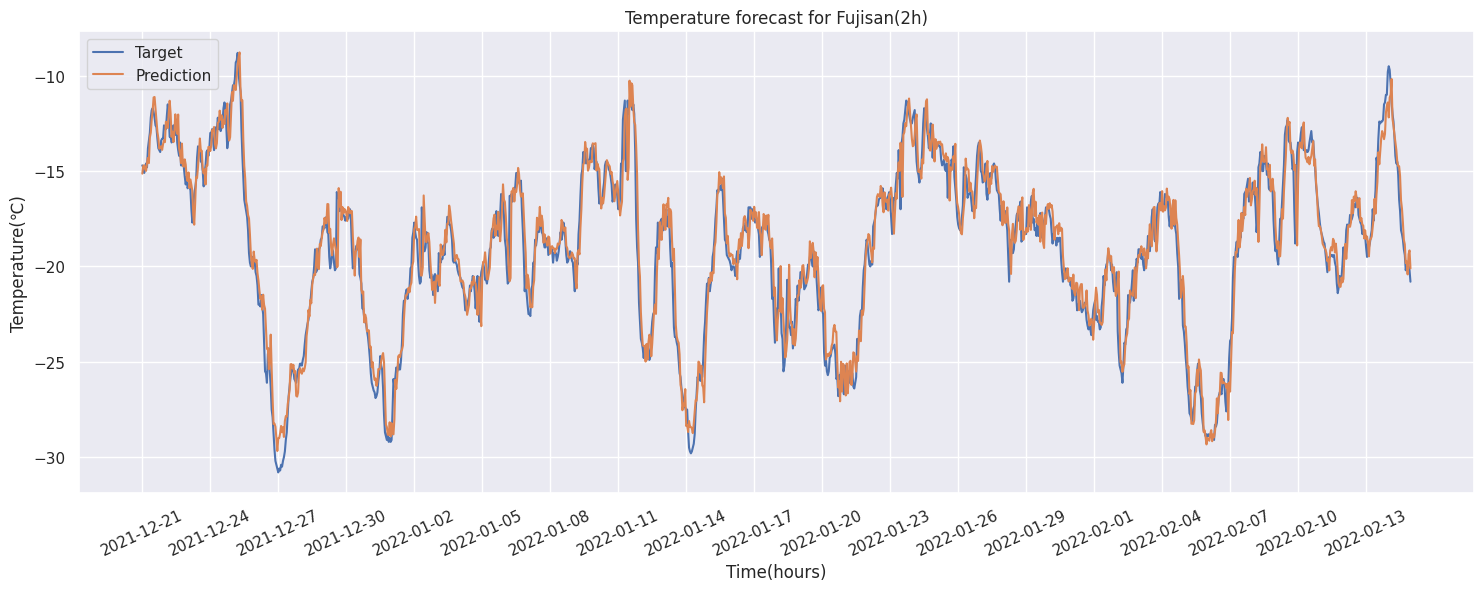

RMSE 1.1262323730647577


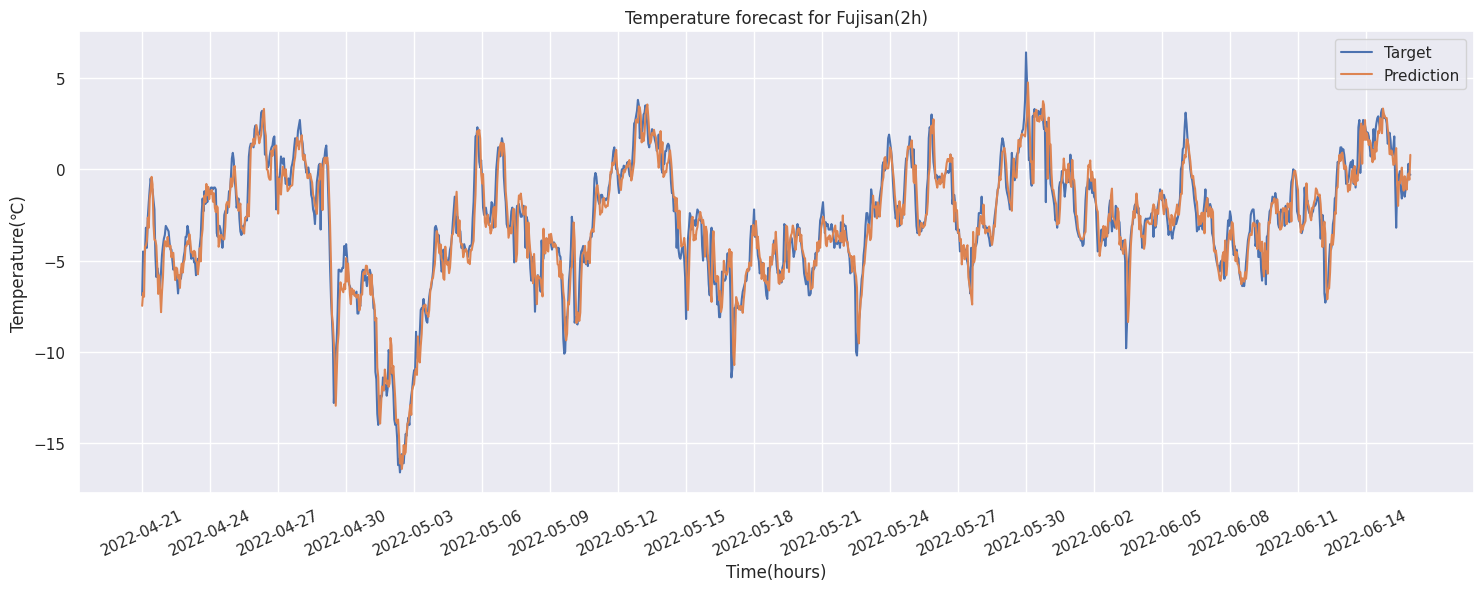

RMSE 1.0986825791177526


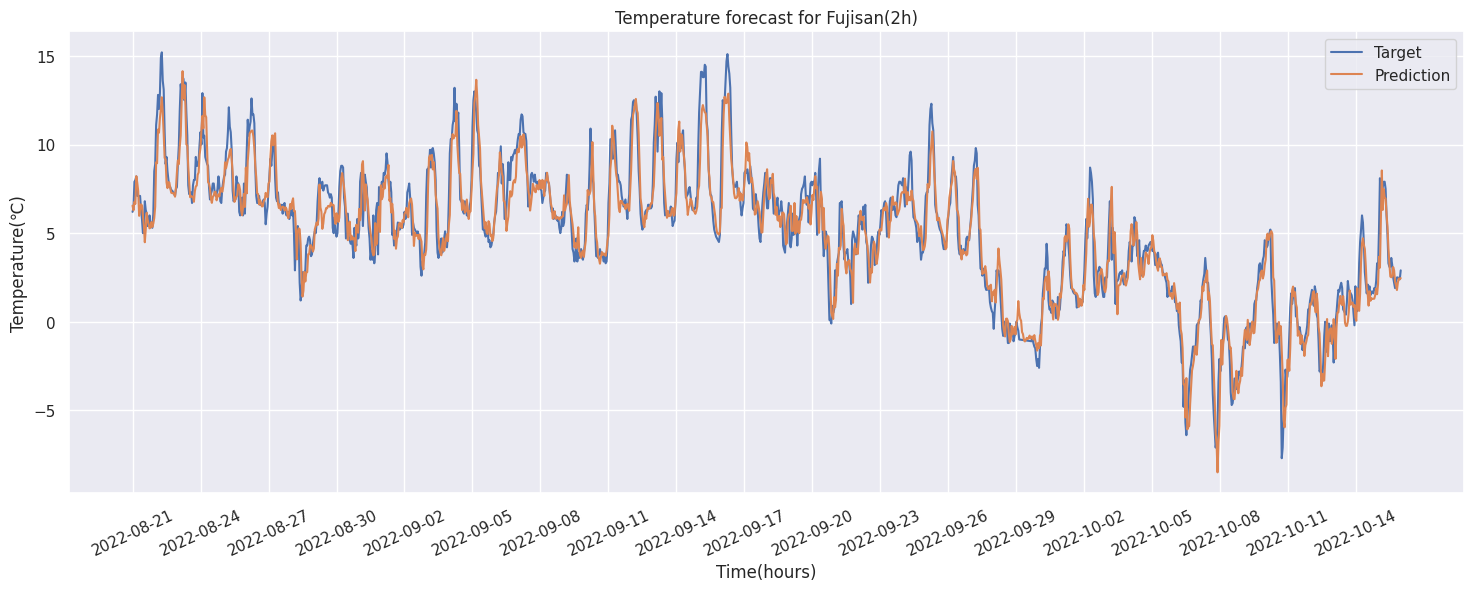

In [8]:
fixed_params = {'patience' : 15,
                'verbose' : 10,
                'n_estimators' : 10000}

runner_lgall.run_val(fixed_params, p='f', h=h) # See the validation results

In [9]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : True,
                'seed' : 42}

runner_lgall.run_train_all(fixed_params) # Train on a tuned model

###Prediction using forecast data

In [10]:
# Apply the model to the test data and check the results

# 2 or 8 hours ahead
testrun = co.TestRun(mf_test_x, mf_test_y)
testrun.runf_test(runner_lgall.model, news_data, f3144_data, mf_test_x.columns, ts_time=t, loc='Temperature_Fujisan')
testrun.df_rmse

'''
# 7 or 9 hours ahead
testrun = co.TestRun(mf_test_x, mf_test_y)
testrun.runf_test_without_f3144(runner_lgall.model, news_data, mf_test_x.columns, ts_time=t, loc='Temperature_Fujisan')
testrun.df_rmse
'''

"\n# 7 or 9 hours ahead\ntestrun = co.TestRun(mf_test_x, mf_test_y)\ntestrun.runf_test_without_f3144(runner_lgall.model, news_data, mf_test_x.columns, ts_time=t, loc='Temperature_Fujisan')\ntestrun.df_rmse\n"

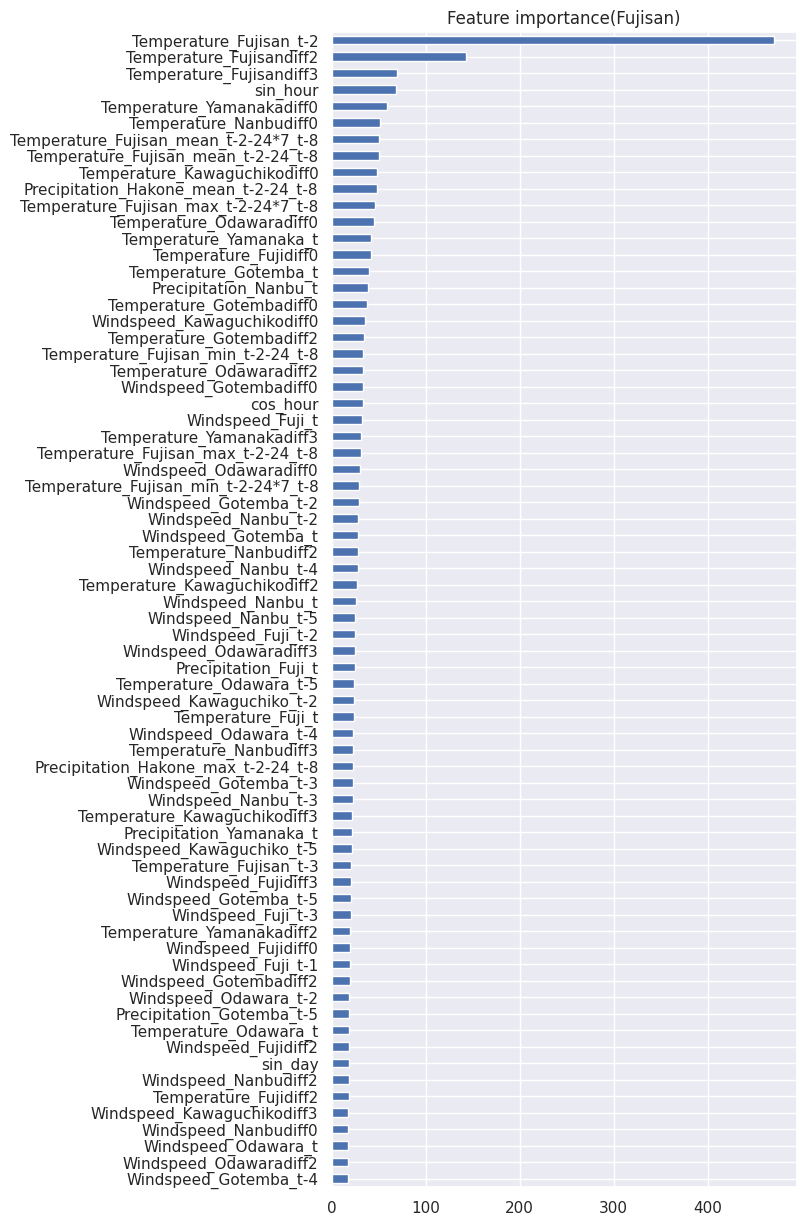

In [11]:
runner_lgall.run_importanace(title='Feature importance(Fujisan)', figsize=(6,15), top=70) # Compute important features

In [12]:
runner_lgall.top_cols = np.union1d(np.array(['sin_day', 'cos_day', 'sin_hour', 'cos_hour']), runner_lgall.top_cols)
mf_train_x_top = mf_train_x_all[runner_lgall.top_cols]
mf_train_x_top.head()

,Precipitation_Fuji_t,Precipitation_Gotemba_t-5,Precipitation_Hakone_max_t-2-24_t-8,Precipitation_Hakone_mean_t-2-24_t-8,Precipitation_Nanbu_t,Precipitation_Yamanaka_t,Temperature_Fuji_t,Temperature_Fujidiff0,Temperature_Fujidiff2,Temperature_Fujisan_max_t-2-24*7_t-8,...,Windspeed_Odawara_t,Windspeed_Odawara_t-2,Windspeed_Odawara_t-4,Windspeed_Odawaradiff0,Windspeed_Odawaradiff2,Windspeed_Odawaradiff3,cos_day,cos_hour,sin_day,sin_hour
2019-07-03 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,26.1,0.4,-0.9,8.7,...,1.9,2.4,2.7,0.2,-0.1,-0.2,0.998667,-7.071068e-01,0.05162,-0.707107
2019-07-03 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,25.3,-0.8,-0.7,8.7,...,1.6,1.7,2.5,-0.3,-0.7,-0.1,0.998667,-5.000000e-01,0.05162,-0.866025
2019-07-03 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,25.1,-0.2,0.4,8.7,...,1.6,1.9,2.4,0.0,0.2,-0.7,0.998667,-2.588190e-01,0.05162,-0.965926
2019-07-03 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,24.6,-0.5,-0.8,8.7,...,1.4,1.6,1.7,-0.2,-0.3,0.2,0.998667,-1.836970e-16,0.05162,-1.000000
2019-07-03 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,24.2,-0.4,-0.2,8.7,...,1.6,1.6,1.9,0.2,0.0,-0.3,0.998667,2.588190e-01,0.05162,-0.965926


## LightGBM

In [13]:
fixed_params = {'patience' : 10,
                'verbose' : 0,
                'n_estimators' : 10000}

runner_lgtop = co.Runner(model.Lgbm, mf_train_x_top, mf_train_y)
runner_lgtop.run_opt(bayes_objective_mt, fixed_params=fixed_params, n_trials=100, seed=42)

[I 2023-08-25 13:02:35,985] A new study created in memory with name: no-name-7dfa9a5e-a24e-45c8-9c85-6d0bc80d5ed5
[I 2023-08-25 13:02:37,290] Trial 0 finished with value: 1.1158314170695869 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 1.1158314170695869.
[I 2023-08-25 13:02:38,354] Trial 1 finished with value: 1.1585538359906689 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 1.1158314170695869.
[I 2023-08-25 13:02:41,349] Trial 2 finished with value: 1.1325879382256805 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 1.1158314170695869.
[I 2023-08-25 13:02:42,642] Trial 3 finished with value: 1.1651410709853263 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, 

best params {'num_leaves': 28, 'colsample_bytree': 0.75, 'subsample': 0.5, 'min_child_samples': 22, 'max_depth': 7}
best score 1.111


RMSE 1.10839493359771


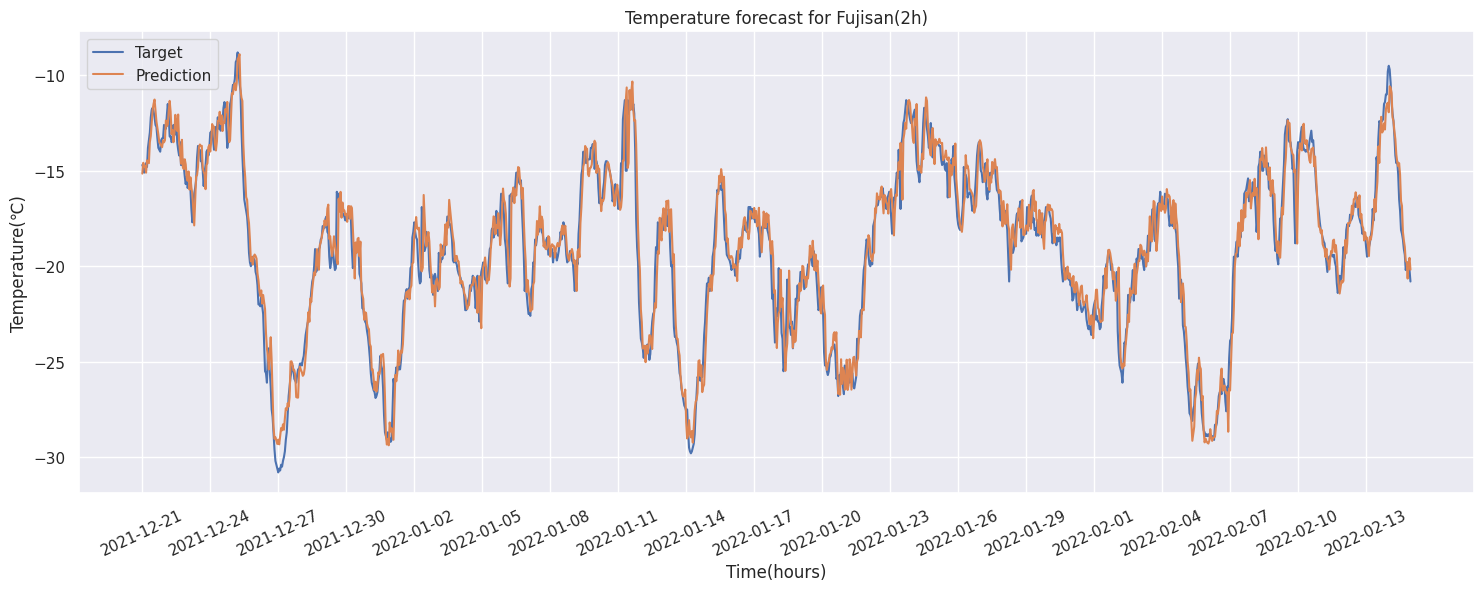

RMSE 1.1311074976372546


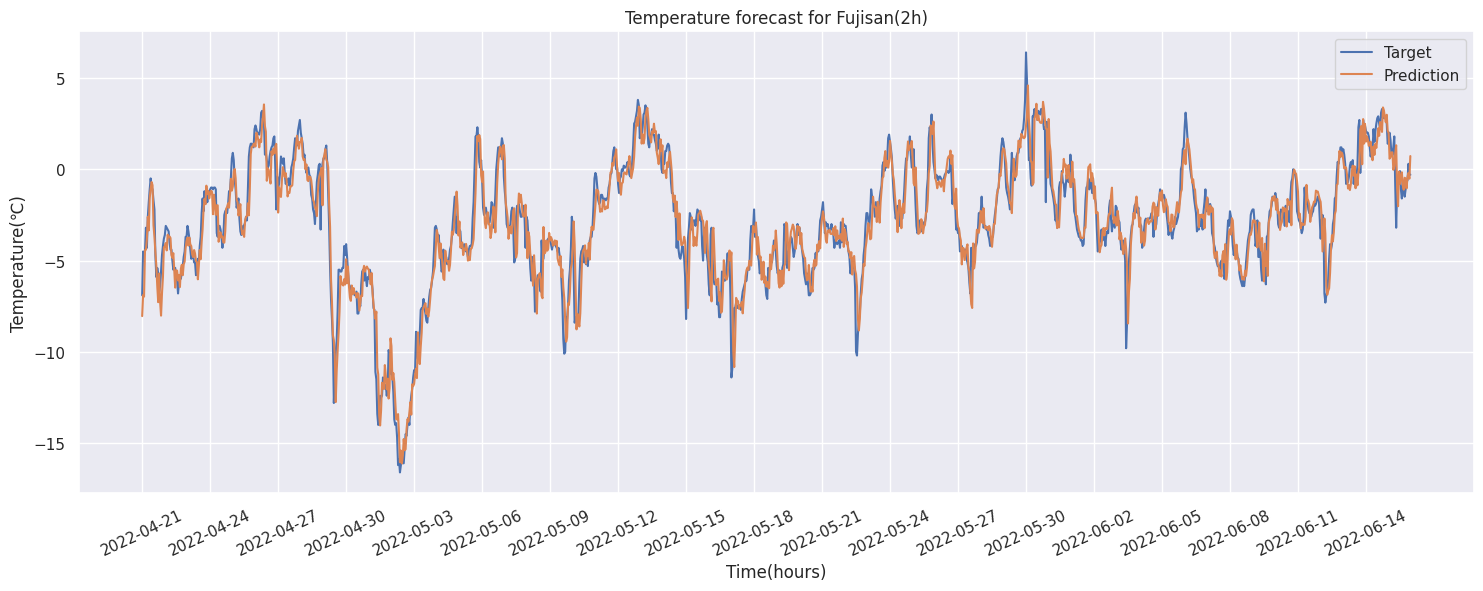

RMSE 1.0930386343182197


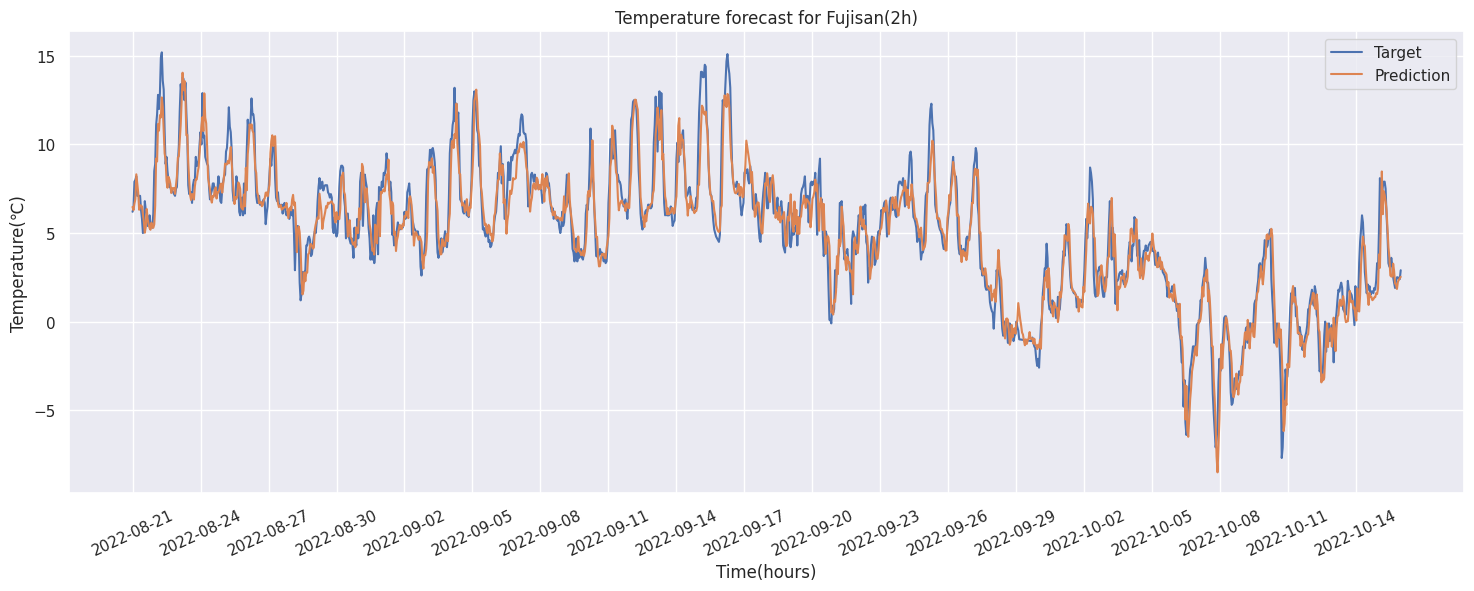

In [14]:
fixed_params = {'patience' : 15,
                'verbose' : 20,
                'n_estimators' : 10000}

runner_lgtop.run_val(fixed_params, p='f', h=h, savefig=True)

In [15]:
fixed_params = {'patience' : False,
                'verbose' : 10,
                'n_estimators' : 100}

runner_lgtop.run_train_all(fixed_params)

In [16]:
testrun.test_x[runner_lgall.top_cols]

,Precipitation_Fuji_t,Precipitation_Gotemba_t-5,Precipitation_Hakone_max_t-2-24_t-8,Precipitation_Hakone_mean_t-2-24_t-8,Precipitation_Nanbu_t,Precipitation_Yamanaka_t,Temperature_Fuji_t,Temperature_Fujidiff0,Temperature_Fujidiff2,Temperature_Fujisan_max_t-2-24*7_t-8,...,Windspeed_Odawara_t,Windspeed_Odawara_t-2,Windspeed_Odawara_t-4,Windspeed_Odawaradiff0,Windspeed_Odawaradiff2,Windspeed_Odawaradiff3,cos_day,cos_hour,sin_day,sin_hour
2022-10-16 09:00:00,0.0,0.0,0.5,0.041667,0.0,0.000000,22.553952,1.668422,0.8,8.1,...,1.178549,0.7,1.3,0.410751,-0.1,-0.5,0.962309,-0.707107,0.271958,0.707107
2022-10-17 09:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,23.344259,2.048611,0.7,8.1,...,1.413719,0.2,1.1,0.570079,-0.9,0.0,0.957485,-0.707107,0.288482,0.707107
2022-10-18 09:00:00,0.0,0.0,1.0,0.145833,0.0,0.796464,19.606729,-0.159927,0.2,8.1,...,3.747956,1.8,0.3,2.352055,0.9,0.6,0.952378,-0.707107,0.304921,0.707107
2022-10-19 09:00:00,0.0,0.0,1.0,0.187500,0.0,0.000000,15.847705,0.604027,0.5,8.1,...,1.005387,1.3,1.1,0.151610,-0.1,0.3,0.946988,-0.707107,0.321270,0.707107
2022-10-20 09:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,15.633653,2.535792,1.0,8.1,...,1.934748,1.0,1.0,1.274195,0.2,-0.2,0.941317,-0.707107,0.337523,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-04 09:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,10.613278,2.925526,0.4,-9.1,...,0.641390,1.4,1.1,-0.504659,0.3,0.0,0.997630,-0.707107,0.068802,0.707107
2023-03-05 09:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,11.343167,2.406375,-0.1,-9.1,...,4.593739,0.8,0.4,1.838307,0.4,0.0,0.996298,-0.707107,0.085965,0.707107
2023-03-06 09:00:00,0.0,0.0,4.5,0.937500,0.0,0.000000,10.586740,2.618303,-0.2,-9.1,...,1.633727,1.7,1.1,-0.210319,0.1,0.5,0.994671,-0.707107,0.103102,0.707107
2023-03-07 09:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,12.771715,2.933363,0.3,-9.1,...,0.879324,0.9,1.4,-1.175059,-0.1,-0.4,0.992749,-0.707107,0.120208,0.707107


### Prediction using forecast data

In [17]:
# 2 or 8 hours ahead

testrun = co.TestRun(mf_test_x, mf_test_y)
testrun.runf_test(runner_lgtop.model, news_data, f3144_data, runner_lgall.top_cols, ts_time=t, loc='Temperature_Fujisan')
testrun.df_rmse

,LightGBM,Weathernews,Tenki(3775m)
RMSE,1.069,1.688,1.381


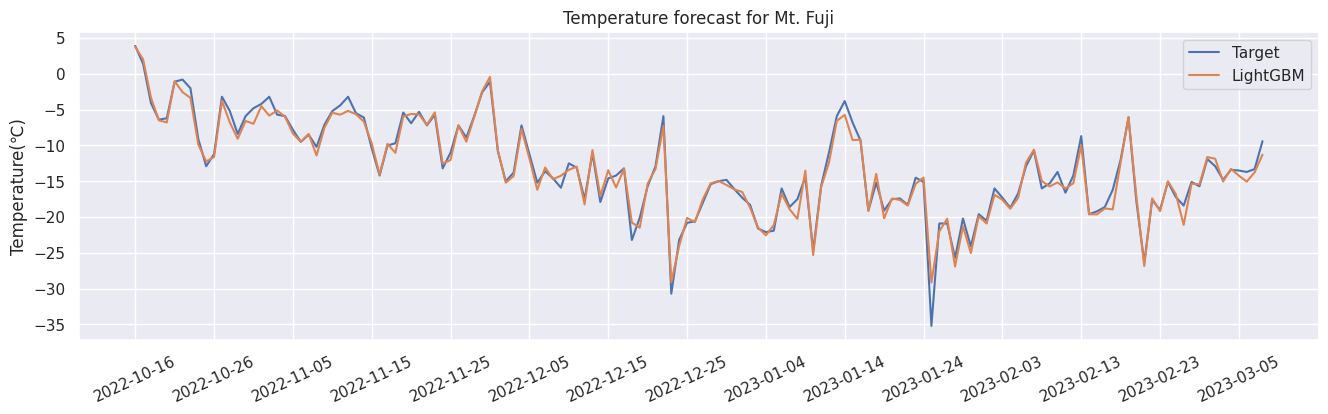

In [18]:
testrun.plot_test(title='Temperature forecast for Mt. Fuji', ylabel='Temperature(℃)', s=None, figsize=(16,4), skip=10)

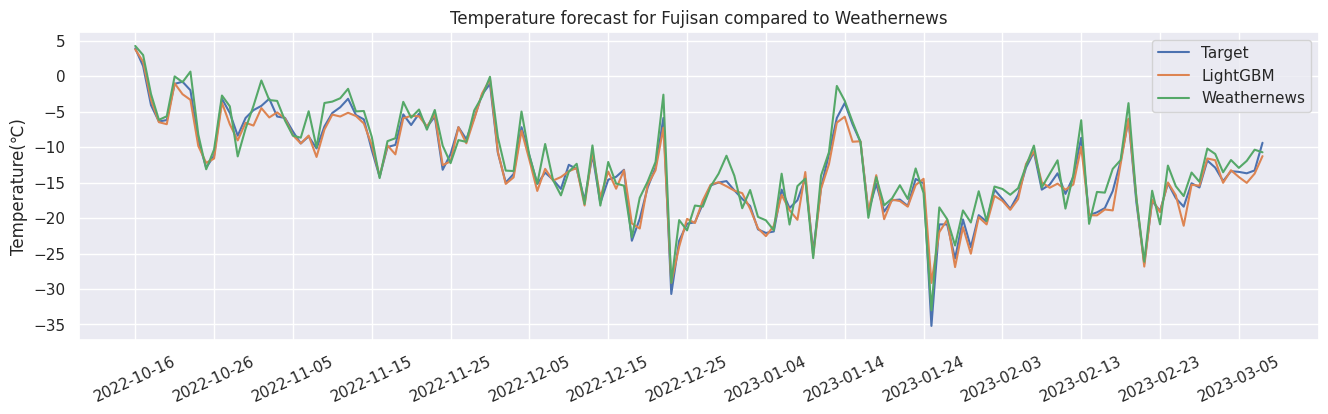

In [19]:
testrun.plot_test(title='Temperature forecast for Fujisan compared to Weathernews', ylabel='Temperature(℃)', s='w', figsize=(16,4), skip=10)

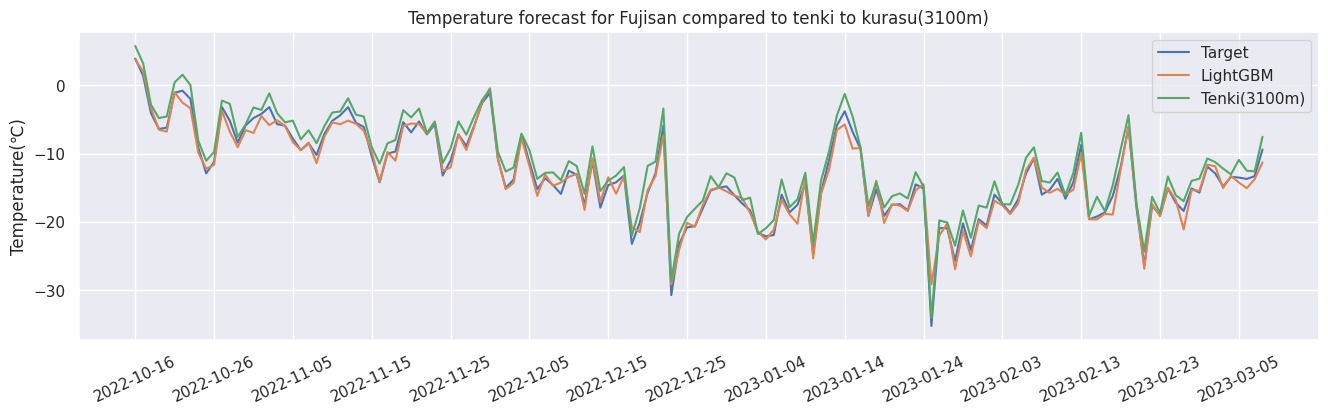

In [20]:
testrun.plot_test(title='Temperature forecast for Fujisan compared to tenki to kurasu(3100m)', ylabel='Temperature(℃)', s='3', figsize=(16,4), skip=10)

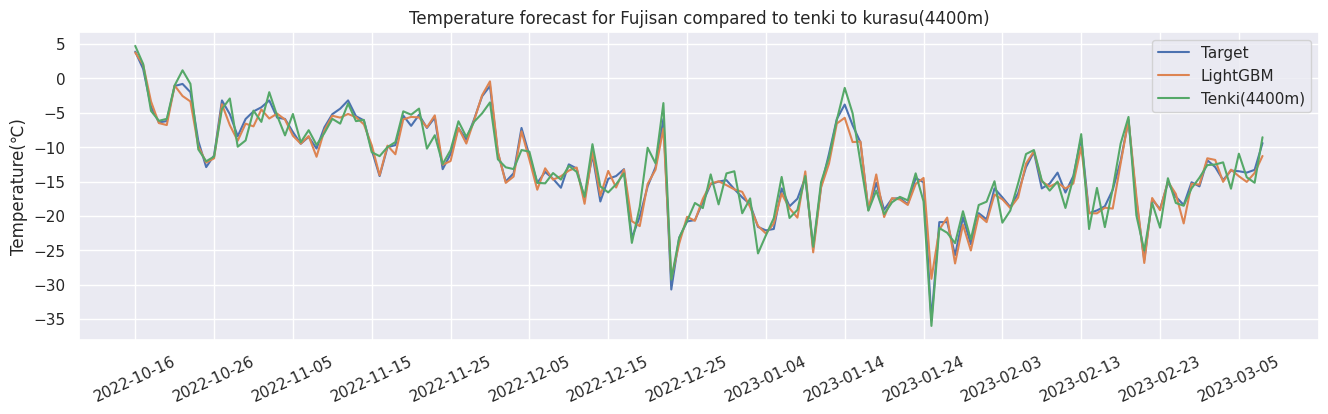

In [21]:
testrun.plot_test(title='Temperature forecast for Fujisan compared to tenki to kurasu(4400m)', ylabel='Temperature(℃)', s='4', figsize=(16,4), skip=10)

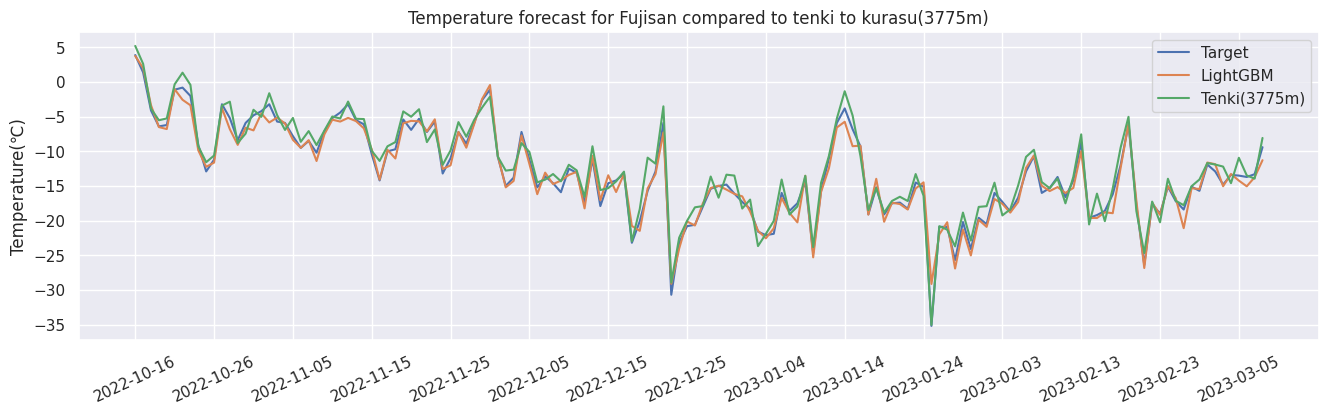

In [22]:
testrun.plot_test(title='Temperature forecast for Fujisan compared to tenki to kurasu(3775m)', ylabel='Temperature(℃)', s='34', figsize=(16,4), skip=10)

In [23]:
# 7 or 9 hours ahead

'''
testrun = co.TestRun(mf_test_x, mf_test_y)
testrun.runf_test_without_f3144(runner_lgtop.model, news_data, runner_lgall.top_cols, ts_time=t, loc='Temperature_Fujisan')
testrun.df_rmse

testrun.plot_test(title='Temperature forecast for Fujisan compared to Weathernews', ylabel='Temperature(℃)', s='w', figsize=(16,4), skip=10)
'''

"\ntestrun = co.TestRun(mf_test_x, mf_test_y)\ntestrun.runf_test_without_f3144(runner_lgtop.model, news_data, runner_lgall.top_cols, ts_time=t, loc='Temperature_Fujisan')\ntestrun.df_rmse\n\ntestrun.plot_test(title='Temperature forecast for Fujisan compared to Weathernews', ylabel='Temperature(℃)', s='w', figsize=(16,4), skip=10)\n"

# Precipitation prediction for Hakone

In [24]:
h='(2h)'
t='09:00:00'
h_train_x_all, h_train_y, h_test_x, h_test_y = md.make_dataset(dataset,news_data,md.get_data_hk_2h,t)

'''
h='(7h)'
t='14:00:00'
h_train_x_all, h_train_y, h_test_x, h_test_y = md.make_dataset(dataset,news_data,md.get_data_hk_7h,t)

h='(8h)'
t='15:00:00'
h_train_x_all, h_train_y, h_test_x, h_test_y = md.make_dataset(dataset,news_data,md.get_data_hk_8h,t)

h='(9h)'
t='16:00:00'
h_train_x_all, h_train_y, h_test_x, h_test_y = md.make_dataset(dataset,news_data,md.get_data_hk_9h,t)
'''

"\nh='(7h)'\nt='14:00:00'\nh_train_x_all, h_train_y, h_test_x, h_test_y = md.make_dataset(dataset,news_data,md.get_data_hk_7h,t)\n\nh='(8h)'\nt='15:00:00'\nh_train_x_all, h_train_y, h_test_x, h_test_y = md.make_dataset(dataset,news_data,md.get_data_hk_8h,t)\n\nh='(9h)'\nt='16:00:00'\nh_train_x_all, h_train_y, h_test_x, h_test_y = md.make_dataset(dataset,news_data,md.get_data_hk_9h,t)\n"

## LightGBM_all_feature

In [25]:
custom_loss, custom_val = co.create_custom_loss(a=16.0, alpha=0.7)  # regression if alppha=1.0

[I 2023-08-25 13:05:27,793] A new study created in memory with name: no-name-d69f82b3-a20e-43d7-a064-7f3590a1dd7c
[I 2023-08-25 13:05:30,993] Trial 0 finished with value: 0.759214440766637 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 0.759214440766637.
[I 2023-08-25 13:05:32,612] Trial 1 finished with value: 0.8063679765939274 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 0.759214440766637.
[I 2023-08-25 13:05:33,973] Trial 2 finished with value: 0.7695224115022284 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 0.759214440766637.
[I 2023-08-25 13:05:35,180] Trial 3 finished with value: 0.7640123182946746 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, 'sub

best params {'num_leaves': 16, 'colsample_bytree': 0.9, 'subsample': 0.85, 'min_child_samples': 30, 'max_depth': 10}
best score 0.75


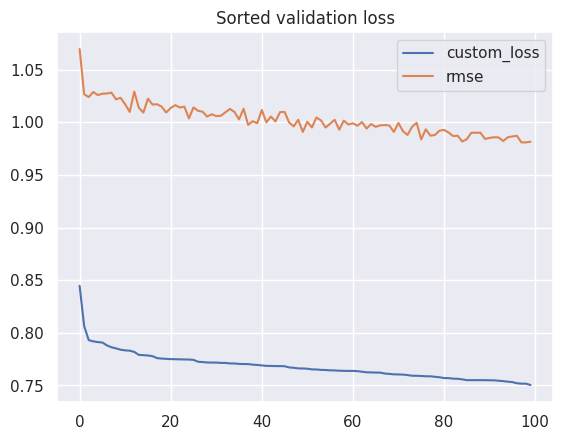

In [26]:
def bayes_objective_h(Model, tr_split, va_split, fixed_params, history = {'val_loss':[], 'rmse':[]}):
    def objective(trial):
        params = {
          'num_leaves': trial.suggest_int('num_leaves', 5, 40, step=1),
          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.05),
          'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
          'min_child_samples': trial.suggest_int('min_child_samples', 20, 40, step=1),
          'max_depth': trial.suggest_int('max_depth', 5, 10, step=1),
          }

        rmse, val_loss = co.get_scores(Model, tr_split=tr_split, va_split=va_split,
                                         fixed_params=fixed_params, params = params)

        history['val_loss'].append(val_loss)
        history['rmse'].append(rmse)
        return  val_loss
    return objective

fixed_params = {'patience' : 10,
          'verbose' : 1,
          'n_estimators' : 10000,
          'objective': custom_loss,
          "metric" : custom_val,
          }

runner_lgall = co.Runner(model.Lgbm, h_train_x_all, h_train_y)
runner_lgall.run_opt(bayes_objective_h, fixed_params, n_trials=100, seed=42)

Custom val loss 0.2937978894570742
RMSE 0.3739345046876807


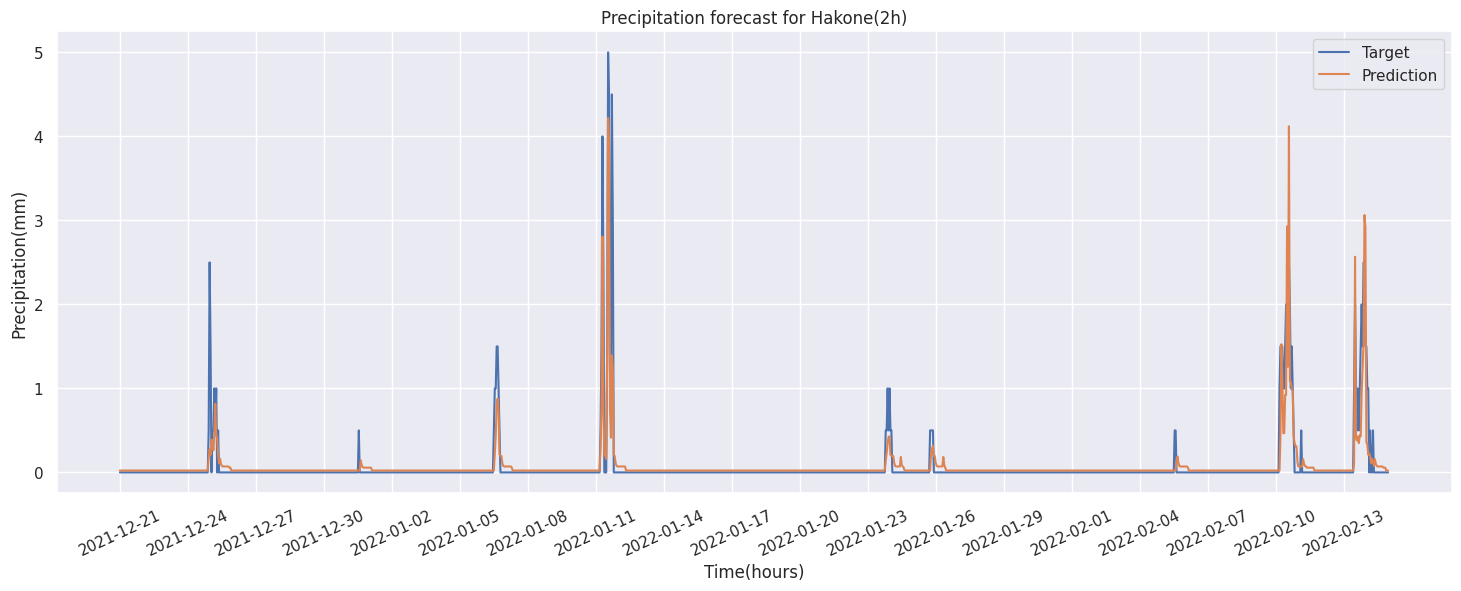

Custom val loss 0.682667418660525
RMSE 0.9023303064417091


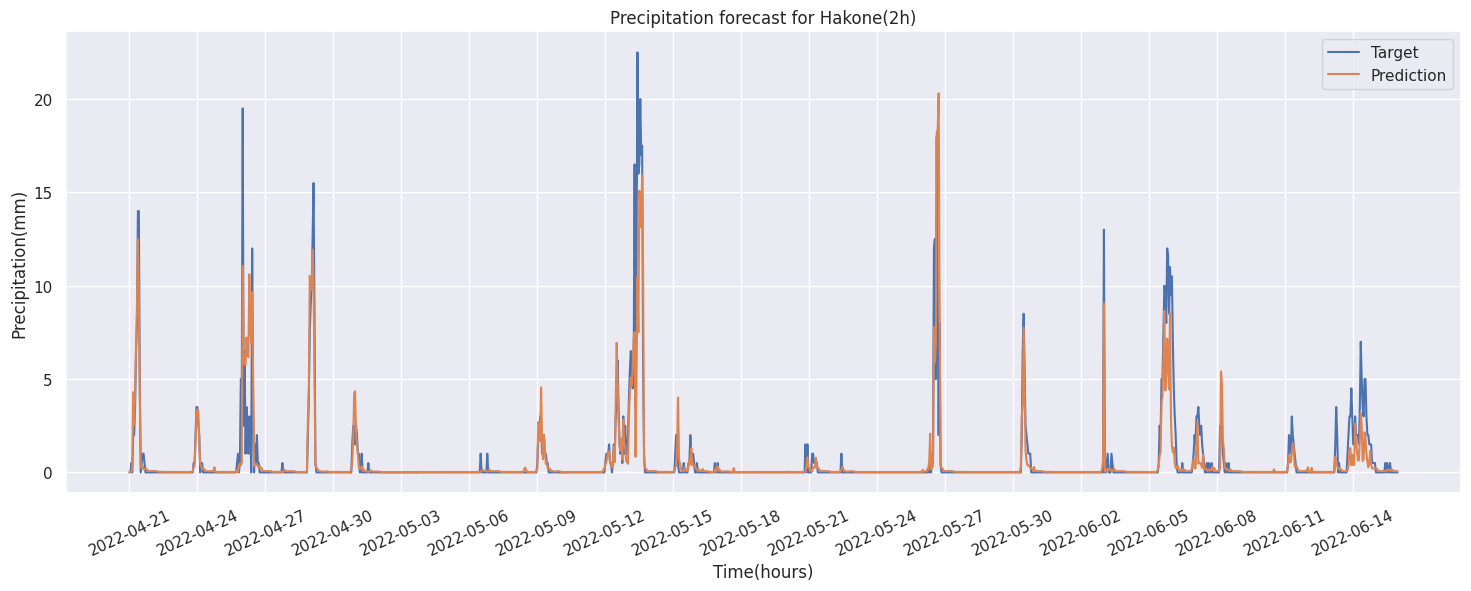

Custom val loss 1.2749121319251095
RMSE 1.6680502380983


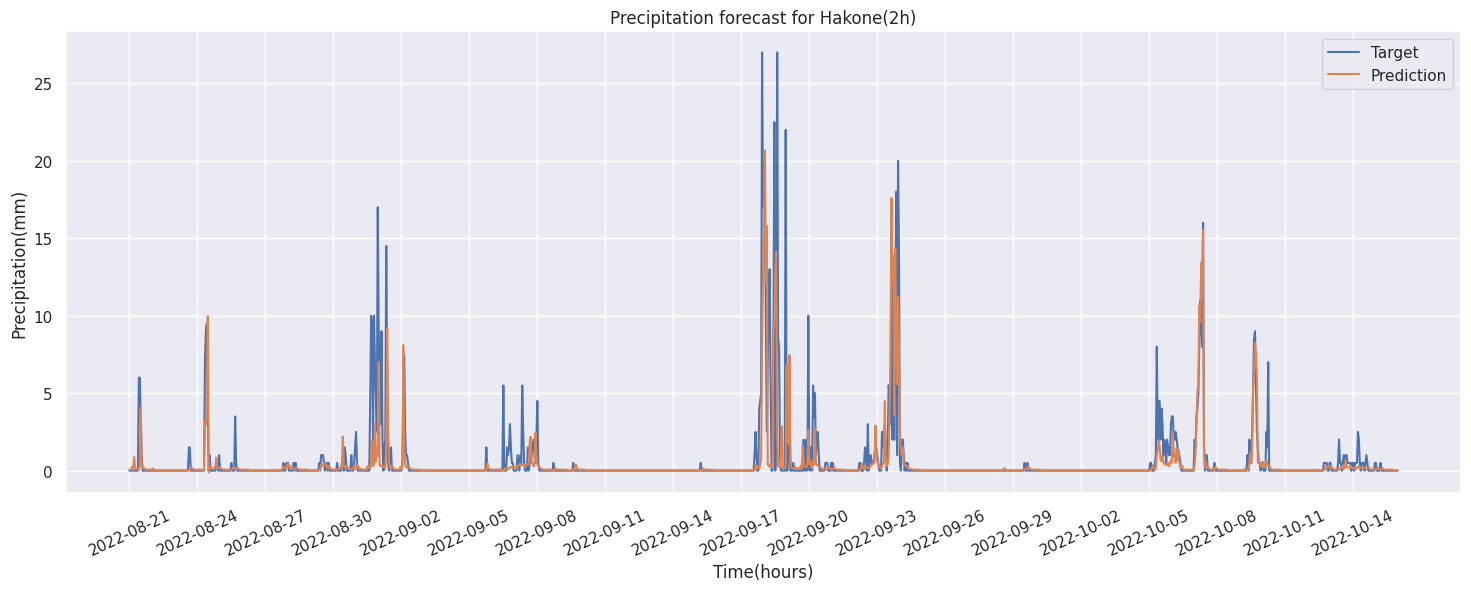

In [27]:
fixed_params = {'patience' : 15,
          'verbose' : 1,
          'n_estimators' : 10000,
          'objective': custom_loss,
          "metric" : custom_val,
          }
runner_lgall.run_val(fixed_params, p='h', h=h)

In [28]:
fixed_params = {'patience' : False,
          'verbose' : 1,
          'n_estimators' : 100,
          'objective': custom_loss,
          "metric" : custom_val,
          }

runner_lgall.run_train_all(fixed_params)

### Prediction using forecast data

In [29]:
testrun = co.TestRun(h_test_x, h_test_y)
testrun.runh_test(runner_lgall.model, news_data, h_test_x.columns, ts_time=t, loc='Precipitation_Hakone')
testrun.df_rmse

,LightGBM,LightGBM_threshold,Weathernews
RMSE,0.518,0.519,0.262


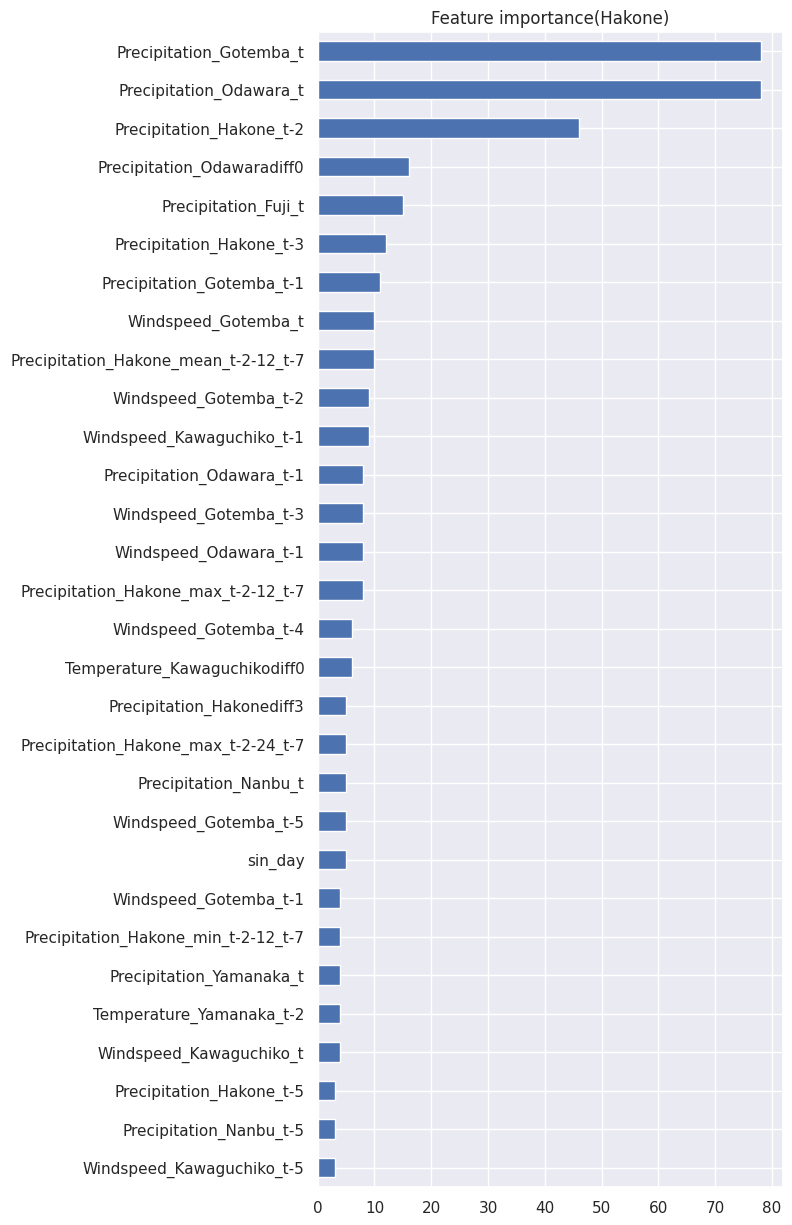

In [30]:
runner_lgall.run_importanace(title='Feature importance(Hakone)', figsize=(6,15), top=30)

In [31]:
runner_lgall.top_cols = np.union1d(np.array(['sin_day', 'cos_day']), runner_lgall.top_cols)

h_train_x_top = h_train_x_all[runner_lgall.top_cols]
h_train_x_top.head()

,Precipitation_Fuji_t,Precipitation_Gotemba_t,Precipitation_Gotemba_t-1,Precipitation_Hakone_max_t-2-12_t-7,Precipitation_Hakone_max_t-2-24_t-7,Precipitation_Hakone_mean_t-2-12_t-7,Precipitation_Hakone_min_t-2-12_t-7,Precipitation_Hakone_t-2,Precipitation_Hakone_t-3,Precipitation_Hakone_t-5,...,Windspeed_Gotemba_t-2,Windspeed_Gotemba_t-3,Windspeed_Gotemba_t-4,Windspeed_Gotemba_t-5,Windspeed_Kawaguchiko_t,Windspeed_Kawaguchiko_t-1,Windspeed_Kawaguchiko_t-5,Windspeed_Odawara_t-1,cos_day,sin_day
2019-07-03 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.1,2.0,2.6,2.7,2.2,2.3,0.8,1.7,0.998667,0.05162
2019-07-03 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.1,2.0,2.6,2.1,2.2,0.8,1.9,0.998667,0.05162
2019-07-03 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.1,3.0,2.1,2.0,1.5,2.1,1.7,1.6,0.998667,0.05162
2019-07-03 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.2,2.1,3.0,2.1,2.1,1.5,2.5,1.6,0.998667,0.05162
2019-07-03 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.4,3.2,2.1,3.0,2.2,2.1,2.3,1.4,0.998667,0.05162


## LightGBM

[I 2023-08-25 13:08:12,414] A new study created in memory with name: no-name-7383b6d6-b265-41bb-8b53-d27869ff708c
[I 2023-08-25 13:08:12,837] Trial 0 finished with value: 0.7472848741808745 and parameters: {'num_leaves': 18, 'colsample_bytree': 1.0, 'subsample': 0.75, 'min_child_samples': 32, 'max_depth': 5}. Best is trial 0 with value: 0.7472848741808745.
[I 2023-08-25 13:08:13,573] Trial 1 finished with value: 0.7870513629974653 and parameters: {'num_leaves': 10, 'colsample_bytree': 0.15000000000000002, 'subsample': 0.9, 'min_child_samples': 32, 'max_depth': 9}. Best is trial 0 with value: 0.7472848741808745.
[I 2023-08-25 13:08:14,030] Trial 2 finished with value: 0.7669266248268629 and parameters: {'num_leaves': 5, 'colsample_bytree': 1.0, 'subsample': 0.85, 'min_child_samples': 24, 'max_depth': 6}. Best is trial 0 with value: 0.7472848741808745.
[I 2023-08-25 13:08:14,490] Trial 3 finished with value: 0.7778486943466847 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.35, 

best params {'num_leaves': 36, 'colsample_bytree': 0.9500000000000001, 'subsample': 0.7000000000000001, 'min_child_samples': 24, 'max_depth': 7}
best score 0.728


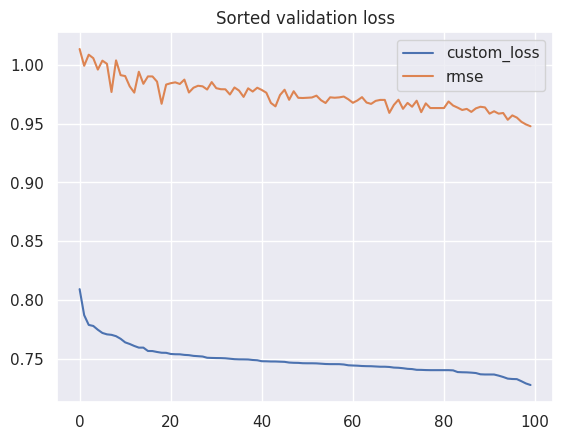

In [32]:
fixed_params = {'patience' : 10,
          'verbose' : 1,
          'n_estimators' : 10000,
          'objective': custom_loss,
          'metric' : custom_val,
          }

runner_lgtop = co.Runner(model.Lgbm, h_train_x_top, h_train_y)
runner_lgtop.run_opt(bayes_objective_h, fixed_params, n_trials=100, seed=42)

Custom val loss 0.2607678732028636
RMSE 0.3301918209880453


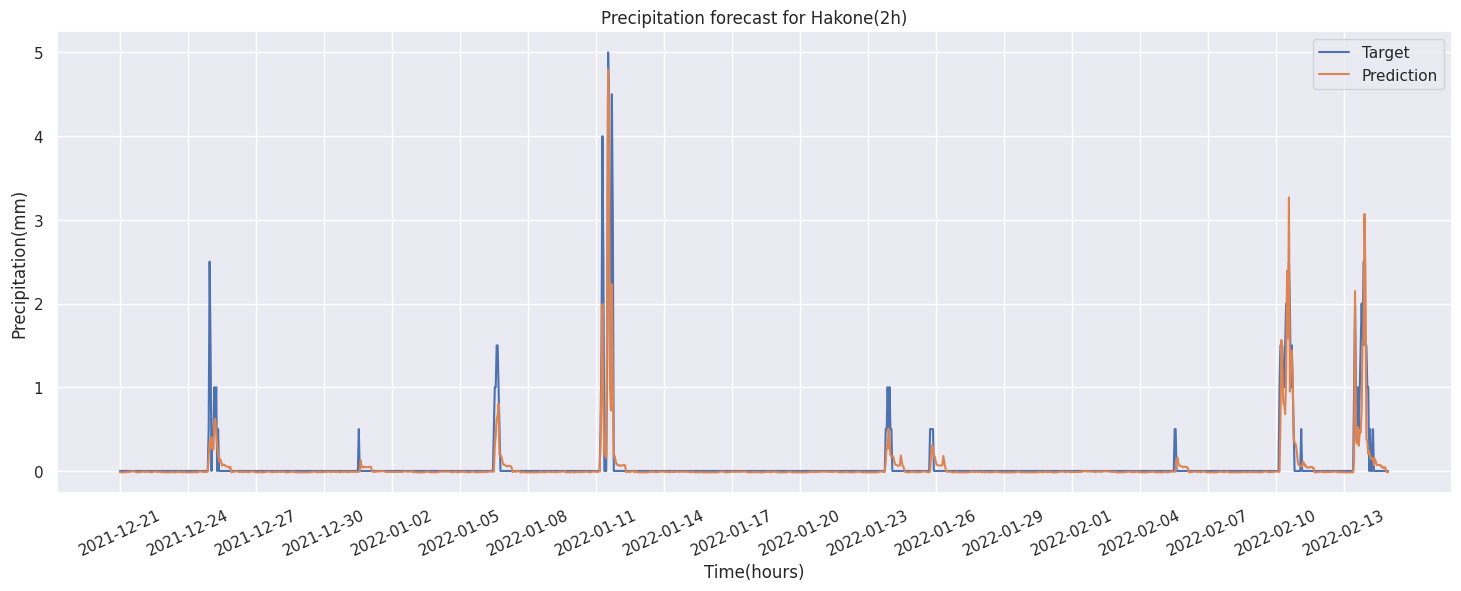

Custom val loss 0.6649328656229935
RMSE 0.8754997787240695


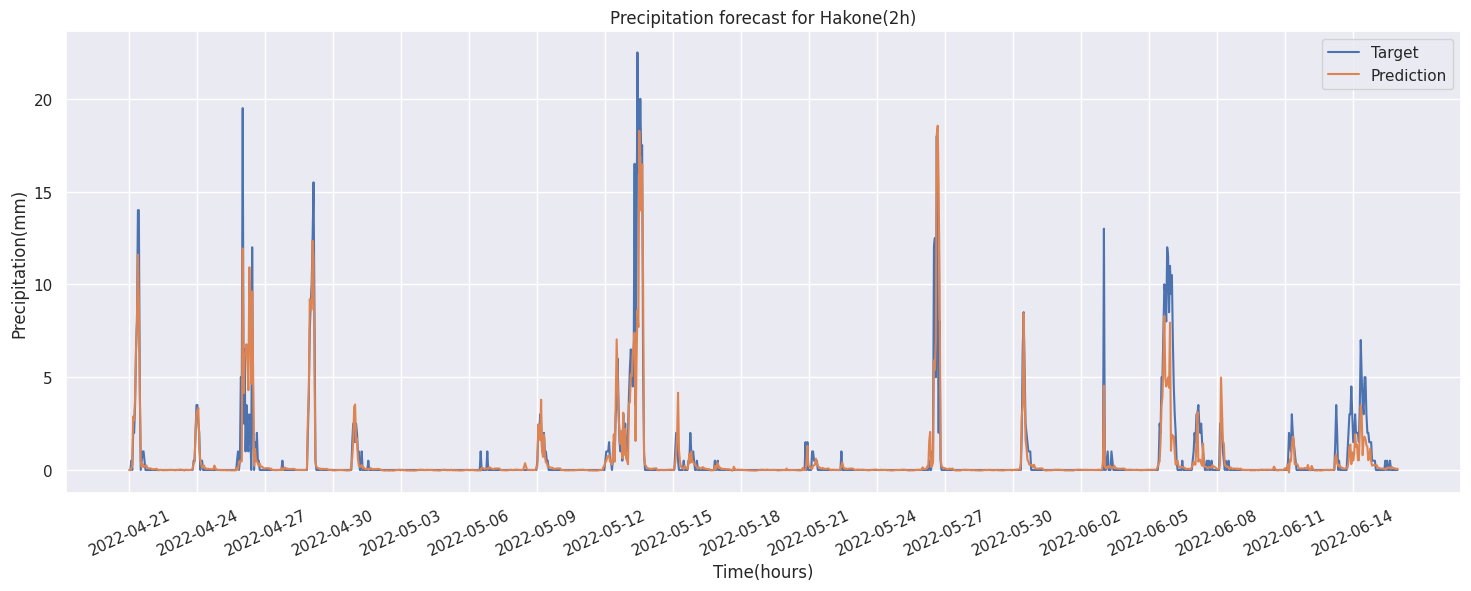

Custom val loss 1.257004355383431
RMSE 1.637874412831739


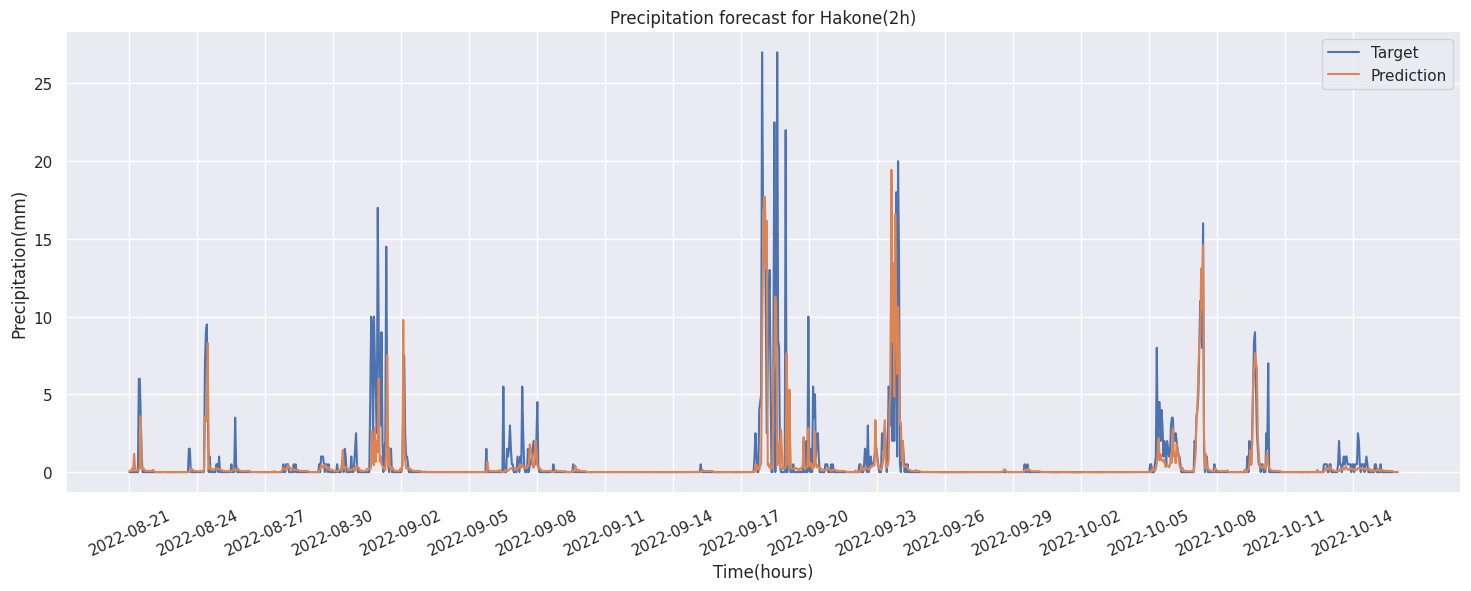

In [33]:
fixed_params = {'patience' : 15,
          'verbose' : 20,
          'n_estimators' : 10000,
          'objective': custom_loss,
          'metric' : custom_val,
          }

runner_lgtop.run_val(fixed_params, p='h', h=h, savefig=True)

In [34]:
fixed_params = {'patience' : False,
                'verbose' : 1,
                'n_estimators' : 100,
                'objective': custom_loss,
                "metric" : custom_val,
                }

runner_lgtop.run_train_all(fixed_params)

### Prediction using forecast data

In [35]:
testrun = co.TestRun(h_test_x, h_test_y)
testrun.runh_test(runner_lgtop.model, news_data, runner_lgall.top_cols, ts_time=t, loc='Precipitation_Hakone')
testrun.df_rmse

,LightGBM,LightGBM_threshold,Weathernews
RMSE,0.604,0.606,0.262


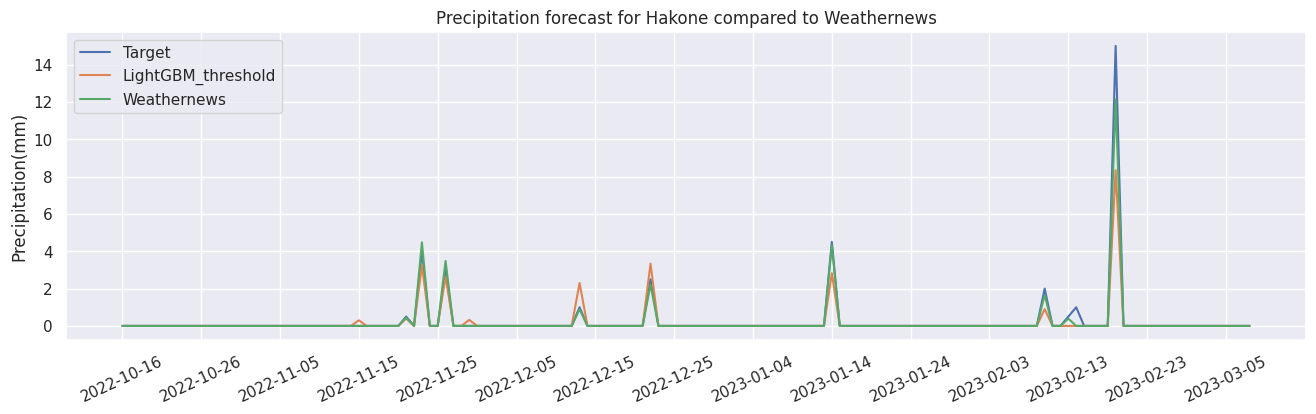

In [36]:
testrun.plot_test(title='Precipitation forecast for Hakone compared to Weathernews',
                   ylabel='Precipitation(mm)', s='w', figsize=(16,4), skip=10, threshold=True)